In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
from pendulum import DoublePendulum
from models import LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

In [8]:
trajectory = pd.read_csv('data/trajectory.csv').values

In [9]:
trajectory

array([[ 1.04719755,  0.        , -0.34906585,  0.        ],
       [ 1.04688436, -0.06263875, -0.34882205,  0.0487726 ],
       [ 1.04594474, -0.12528622, -0.34808986,  0.09770677],
       ...,
       [-0.8657595 ,  1.65169439,  6.17191787, -1.47565217],
       [-0.8488802 ,  1.7242311 ,  6.15671181, -1.56597499],
       [-0.8312734 ,  1.79718278,  6.14059022, -1.65871742]])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)

input_dim = 4
output_dim = 4
hidden_size = 100
num_layers = 4

model = LSTM(input_dim = input_dim,
             output_dim=output_dim, 
             hidden_size = hidden_size,
             num_layers = num_layers).to(device)

device =  cpu


In [25]:
proportion_train = 0.8
cutoff = int(proportion_train * trajectory.shape[0])
train_trajectory = trajectory[:cutoff]
test_trajectory = trajectory[cutoff:]
scalar = MinMaxScaler(feature_range=(-1,1))
train_trajectory_normalized = scalar.fit_transform(trajectory)
test_trajectory_normalized = scalar.transform(test_trajectory)

class StockDataset(Dataset):
    def __init__(self, data, seq_len = None):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1, 4)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]

lookback = 40

train_dataset = StockDataset(train_trajectory_normalized, seq_len=lookback)
test_dataset = StockDataset(test_trajectory_normalized, seq_len=lookback)
batch_size = 64
epochs = 2000

train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size, drop_last=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 50.64batch/s, test_loss=0.288]


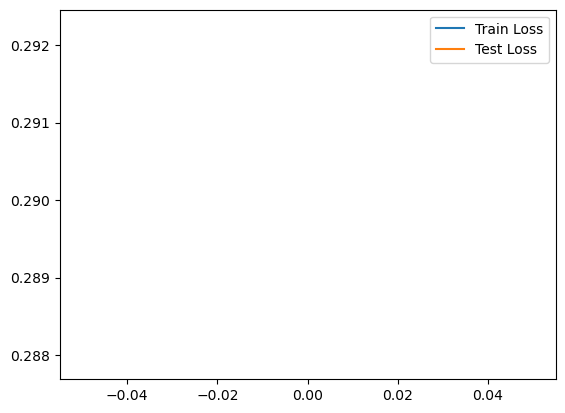

Epoch 2 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 48.75batch/s, test_loss=0.288]


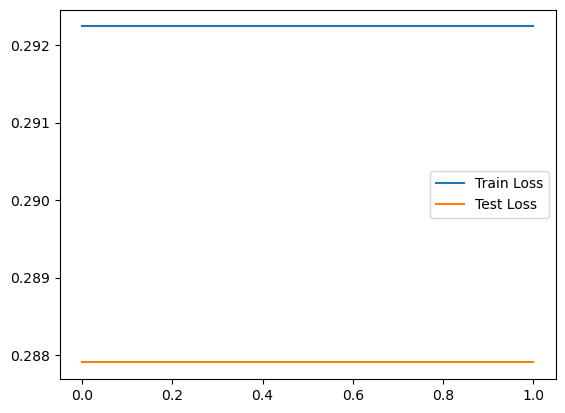

Epoch 3 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 44.57batch/s, test_loss=0.288]


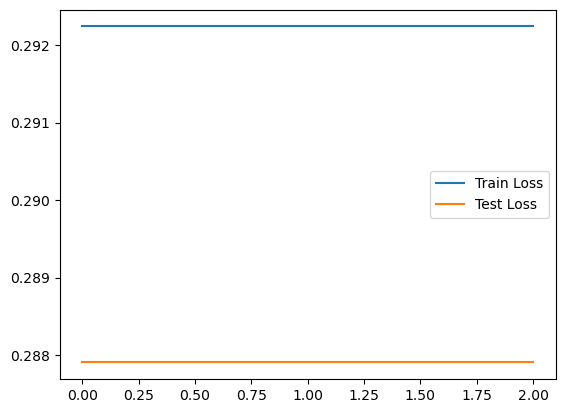

Epoch 4 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 48.79batch/s, test_loss=0.288]


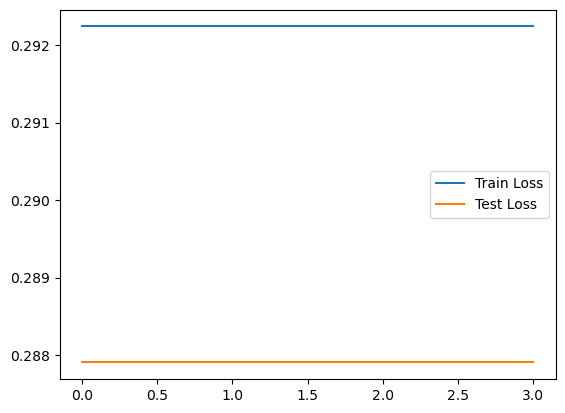

Epoch 5 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 48.45batch/s, test_loss=0.288]


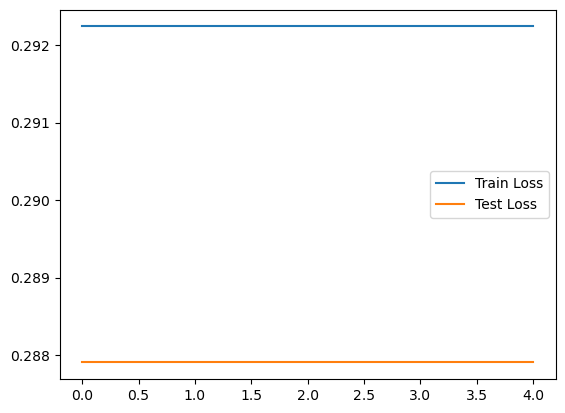

Epoch 6 of 10


Testing batch 61/61: 100%|██████████| 61/61 [00:01<00:00, 41.91batch/s, test_loss=0.288]


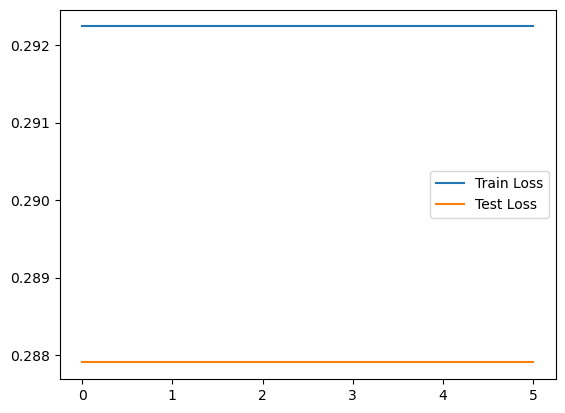

Epoch 7 of 10


Testing batch 43/61:  69%|██████▉   | 42/61 [00:00<00:00, 45.63batch/s, test_loss=0.295]


KeyboardInterrupt: 

In [27]:
train_losses = []
test_losses = []
best_test_loss = float("inf")
patience = 5
patience_count = 0

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}")
    train_loss = 0.0
    test_loss = 0.0

    # Train
    model.train()
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for i, (x, y) in enumerate(tepoch):
            tepoch.set_description(f"Training batch {i+1}/{len(train_dataloader)}")
            x = x.to(device)
            y = y.to(device)
            hn, cn = model.init(batch_size=batch_size)
            out, hn, cn = model(x.reshape(lookback, batch_size, output_dim), hn, cn)
            loss = loss_fn(out, y)
            hn = hn.detach()
            cn = cn.detach()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            tepoch.set_postfix(train_loss=train_loss / (i + 1))

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Test
    model.eval()
    with tqdm(test_dataloader, unit="batch") as tepoch:
        for i, (x, y) in enumerate(tepoch):
            tepoch.set_description(f"Testing batch {i+1}/{len(test_dataloader)}")
            x = x.to(device)
            y = y.to(device)
            hn, cn = model.init(batch_size=batch_size)
            out, hn, cn = model(x.reshape(lookback, batch_size, output_dim), hn, cn)
            loss = loss_fn(out, y)
            test_loss += loss.item()
            tepoch.set_postfix(test_loss=test_loss / (i + 1))

    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_count = 0
    else:
        patience_count += 1
        if patience_count == patience:
            print(f"\nEarly stopping: no improvement in {patience} epochs")
            break

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.legend()
    plt.show()


In [19]:
torch.save(model.state_dict(), 'models/lstm')